In [1]:
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance_matrix
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc_file
#rc_file('/home/p0friedr/okamp/Programme/Python/plotting/plotstyle.rc') 
import argparse
from os import path
import time
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import linregress
from matplotlib import ticker

In [2]:
# load the data
DF = pd.read_csv("NormalisedReturnsSector.csv", index_col = "Date")
#DF = pd.read_csv("Companies1992_2012.csv",
#                index_col="Date")

In [3]:
# first rows are NaNs because of local renormalisation
print(DF.shape)
DF

(5291, 11)


,Energy,Consumer Discretionary,Financials,Industrials,Utilities,Consumer Staples,Real Estate,Communication Services,Materials,Information Technology,Health Care
Date,,,,,,,,,,,
1992-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,-15.162661,0.946475,-18.817386,-21.914887,-13.140806,-4.858706,-0.294245,-0.863861,3.303588,-14.597120,-12.149445
2012-12-26,-9.763909,-22.927124,-19.146464,-32.016238,-30.861994,-24.124430,-10.870392,-3.661413,-3.646271,-27.670765,-34.542872
2012-12-27,-2.798086,10.674023,-21.539939,-11.556934,-4.524981,1.880229,1.640416,-2.525184,-10.469251,-7.213248,-0.922065


In [4]:
# compute correlation matrices for overlapping, moving intervals
Period = 40 # 2 trading months
Shift = 1
T = int((len(DF) - Period)/Shift)


# because of symmetry and diagonal of 1, only need upper triangle:
Index = np.triu(np.ones((DF.shape[1],
                         DF.shape[1])),1)
print(Index.shape)
print(np.sum(Index))

Index = Index.reshape(1,-1)
Index = Index.astype(bool)
print(Index.shape, np.sum(Index))
CorrMatrices = np.empty((T, np.sum(Index)))
CorrMatricesFull = np.empty((T,int(DF.shape[1]**2.)))

print(len(Index))

for t in range(T):
    #print((0+t*Shift),(Period+t*Shift))
    IntervalDF = DF.iloc[(0+t*Shift):(Period+t*Shift)]
    IntervalCorr = IntervalDF.corr()
    IntervalCorr = IntervalCorr.to_numpy().reshape(1,-1)

    CorrMatricesFull[t,:] = IntervalCorr
    
    # Only save the non-trivial and unique elements of the correlation matrix
    CorrMatrices[t,:] = IntervalCorr[Index]

CorrMatrices.shape   

(11, 11)
55.0
(1, 121) 55
1


(5251, 55)

### True kmeans-approach

And try to sort the labels according to their first appearance in the data.

In [5]:
KMTrue = KMeans(n_clusters = 8,random_state = 12345).fit(CorrMatrices) 

In [6]:
KMTrue.predict(CorrMatrices)

array([7, 7, 4, ..., 6, 6, 2], dtype=int32)

In [7]:
TimeIndex = DF.index[20:(len(DF.index)-20)]
T = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in TimeIndex]

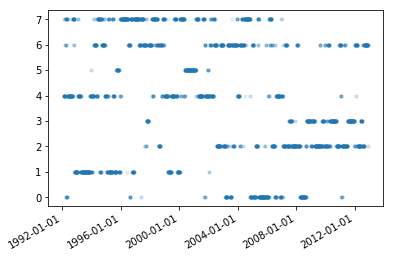

In [8]:
LabelNaive = KMTrue.predict(CorrMatrices)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaive, ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [9]:
Indexshift = np.zeros(((max(LabelNaive)+1),2)).astype("int") # keep track of which cluster is assigned which number

Indexshift = pd.DataFrame({"Old Label":[],
                          "New Label":[]})
NewLabel = int(0)
for i in range(len(LabelNaive)):
    if (LabelNaive[i] in set(Indexshift["Old Label"]))==False:
        Indexshift = Indexshift.append(pd.DataFrame({"Old Label":[LabelNaive[i]],
                                                      "New Label":[NewLabel]}), ignore_index=True)
        NewLabel = int(NewLabel+1)
print(Indexshift)

   Old Label  New Label
0        7.0        0.0
1        4.0        1.0
2        6.0        2.0
3        0.0        3.0
4        1.0        4.0
5        5.0        5.0
6        2.0        6.0
7        3.0        7.0


In [10]:
LabelNaiveOrdered = np.empty(len(LabelNaive))

for i in range(len(LabelNaive)):
    LabelNaiveOrdered[i] = int(Indexshift.loc[Indexshift["Old Label"]==LabelNaive[i]]["New Label"])

CentroidsNaive = np.zeros((max(LabelNaive)+1, CorrMatrices.shape[1]))

for j in range(max(LabelNaive)+1): # go through the new orering of the clusters
    Old_Order = int(Indexshift.loc[Indexshift["New Label"]==j]["Old Label"])
    CentroidsNaive[j] = KMTrue.cluster_centers_[Old_Order]

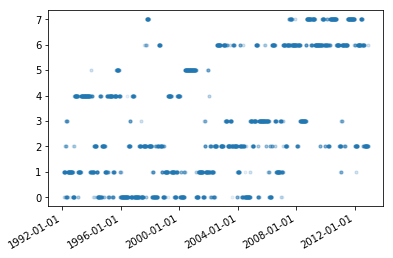

In [11]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaiveOrdered,
         ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [12]:
Indexshift["Old Label"][0]

7.0

In [13]:
for i in range(CentroidsNaive.shape[0]):
    print(sum(KMTrue.cluster_centers_[int(Indexshift["Old Label"][i])]  != CentroidsNaive[i]  ))
#print(KMTrue.cluster_centers_[6])

0
0
0
0
0
0
0
0


## Neuralising kmeans

In [14]:
def layer1(x, centroids, i):
    # takes one instance x, centroid-matrix and index of ith centroid
    # returns values for the distances to centroid i
    mu_c = centroids[i]
    w = 2*(mu_c - centroids)
    b = (centroids**2.).sum(1) - (mu_c**2.).sum()
    h = w.dot(x) + b
    return(h)

def layer2(h,i):
    # i is the index of the cluster which we "test" here
    Indices = np.arange(len(h))
    return(min(h[Indices!=i]) )


def DecisionLayer(Minimum):
    return(Minimum > 0)



def NN_k(x,centroids,k):
    # checks if x belongs to kth cluster
    return(layer2(layer1(x,centroids,k),k))

In [15]:
# Do this for the naive kmeans

nKM = max(LabelNaive) + 1 
print(nKM)


# CHeck for all instances
Layer_Pred2 = np.empty(CorrMatrices.shape[0])

Counter = 0
for i in range(len(Layer_Pred2)): # check all instances
    Counter = 0
    for j in range(nKM): # check all possible clusters
        Decision = DecisionLayer(NN_k(CorrMatrices[i,:],KMTrue.cluster_centers_, j))    
        if Decision:
            Layer_Pred2[i] = range(nKM)[j]
            
            Counter +=1
            
        if Counter > 1:
            print("Problem", i, LabelNaive[i], Layer_Pred2[i])
print("Should be zero:", sum(Layer_Pred2 != LabelNaive))
# So this actually works!!!

8
Should be zero: 0


### LRP Functions

In [16]:
def beta(X, i, DecisionL, NN, Centroids):
    # Takes the Data X, a particular class i, a Decision Layer DecisionL and Neuralised kmeans NN = NN(x,centroids,k)
    # Returns the beta-scaling factor from eq. (3)
    IS_i = np.empty(X.shape[0])
    
    for j in range(X.shape[0]):
        IS_i[j] = NN(X[j,:],
                     Centroids,
                     i)
    return( np.mean(IS_i)**(-1.))
    

In [17]:


def Eq2(X, Centroids, c, beta):
    # take one Data.point X, the cluster Centroids and the cluster of interest c, scaling factor beta
    # output: R_k - array as in equation (2)
    
    n_C = Centroids.shape[0]
    
    H_k = layer1(X, Centroids, c)
    F_c = layer2(H_k, c)
    
    # numerator of eq. (2)
    r_k_func = np.exp(-beta * H_k) * F_c
    
    R_k_out = r_k_func / sum(r_k_func[np.arange(n_C) != c])
    #print(range(n_C), range(n_C) != c)
    return(R_k_out)

In [18]:
def Eq4(X, Centroids, c, beta):

    n_C = Centroids.shape[0]
    Index = (np.arange(n_C) != c) # index of "all clusters except c"
    
    R_previous = Eq2(X, Centroids, c, beta) # from Equation (2)
    R_previous_reduced = R_previous[Index]
    MU_c = Centroids[c]
    M_k = 0.5*(Centroids + MU_c)
    DIFF_x_m = X - M_k
    
    DIFF_x_m_reduced = DIFF_x_m[Index]
    
    W = 2*(MU_c - Centroids)
    W_reduced = W[Index]
    
    Prod = np.multiply(DIFF_x_m_reduced, W_reduced)
    
    R_InputLayer = np.zeros(len(X)) # relevance of each input-feature
    
    for i in range(len(R_InputLayer)):
        for k in range(n_C-1):
            R_InputLayer[i] += Prod[k,i] * R_previous_reduced[k] / np.sum(Prod[k,:])
    
    return(R_InputLayer)

In [19]:

def xai_clust(X, Centroids, X_Label, Dat, DecisionL, Neuralised):

    return(Eq4(X, Centroids,  X_Label,
           beta(Dat, X_Label, DecisionL, Neuralised, Centroids)))


In [20]:
xai_clust(CorrMatrices[0,:], 
          CentroidsNaive, 0, CorrMatrices, 
          DecisionLayer, NN_k).round(1)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

## Go through entire Data

In [21]:
XAI = np.zeros(CorrMatrices.shape)
LabelNaiveOrdered # is the ordered label output

for i in range(CorrMatrices.shape[0]):
    x = CorrMatrices[i,:]
    XAI[i,:] = xai_clust(x, CentroidsNaive, 
                         LabelNaiveOrdered.astype("int")[i],
                         CorrMatrices, DecisionLayer, NN_k)
print(XAI.round(1))

[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [-0.  -0.1 -0.  ...  0.   0.1  0. ]
 ...
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.1  0.  ...  0.   0.   0. ]]


Cluster 0 with centroid [0.38 0.4  0.48 0.35 0.39 0.26 0.36 0.47 0.29 0.42 0.71 0.76 0.49 0.64
 0.48 0.6  0.66 0.51 0.68 0.78 0.57 0.7  0.48 0.64 0.66 0.47 0.72 0.54
 0.7  0.5  0.66 0.77 0.57 0.73 0.56 0.39 0.47 0.51 0.26 0.49 0.41 0.57
 0.63 0.39 0.68 0.37 0.45 0.27 0.43 0.55 0.52 0.61 0.44 0.62 0.55]
And mean importances [0.03 0.03 0.03 0.02 0.02 0.03 0.04 0.02 0.04 0.03 0.01 0.01 0.02 0.02
 0.01 0.01 0.01 0.02 0.01 0.   0.02 0.02 0.02 0.01 0.01 0.02 0.01 0.02
 0.02 0.01 0.01 0.   0.02 0.01 0.01 0.02 0.03 0.02 0.03 0.02 0.02 0.02
 0.01 0.03 0.01 0.02 0.02 0.03 0.02 0.02 0.01 0.02 0.03 0.02 0.02]


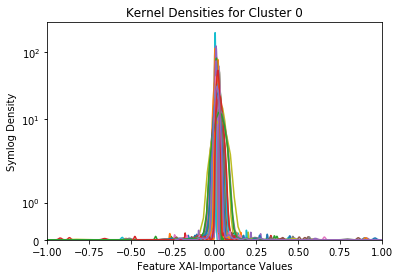

Cluster 1 with centroid [0.18 0.2  0.29 0.24 0.16 0.11 0.22 0.32 0.25 0.25 0.69 0.74 0.26 0.59
 0.43 0.56 0.57 0.65 0.64 0.73 0.39 0.6  0.43 0.59 0.56 0.62 0.65 0.31
 0.56 0.44 0.57 0.73 0.69 0.65 0.41 0.21 0.3  0.26 0.25 0.28 0.3  0.48
 0.48 0.46 0.6  0.33 0.39 0.37 0.38 0.45 0.57 0.51 0.52 0.52 0.61]
And mean importances [0.04 0.03 0.03 0.03 0.04 0.04 0.04 0.03 0.03 0.03 0.   0.   0.03 0.01
 0.02 0.01 0.01 0.01 0.01 0.   0.02 0.01 0.02 0.01 0.01 0.01 0.01 0.03
 0.01 0.02 0.01 0.   0.01 0.01 0.02 0.03 0.02 0.03 0.03 0.03 0.02 0.02
 0.02 0.02 0.01 0.02 0.02 0.02 0.02 0.02 0.01 0.02 0.02 0.02 0.01]


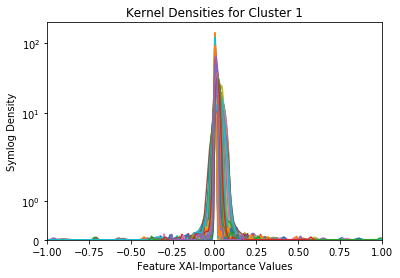

Cluster 2 with centroid [0.53 0.59 0.62 0.45 0.5  0.41 0.54 0.62 0.51 0.57 0.77 0.83 0.47 0.66
 0.56 0.67 0.74 0.69 0.71 0.82 0.53 0.68 0.58 0.72 0.75 0.7  0.76 0.51
 0.69 0.57 0.72 0.84 0.77 0.79 0.54 0.4  0.52 0.49 0.4  0.49 0.43 0.61
 0.65 0.56 0.69 0.48 0.55 0.47 0.51 0.66 0.66 0.69 0.67 0.71 0.71]
And mean importances [0.03 0.04 0.03 0.01 0.02 0.02 0.04 0.03 0.04 0.02 0.01 0.   0.03 0.03
 0.01 0.01 0.01 0.02 0.02 0.01 0.02 0.02 0.01 0.01 0.01 0.02 0.01 0.02
 0.02 0.01 0.01 0.   0.01 0.02 0.01 0.02 0.03 0.02 0.03 0.02 0.02 0.02
 0.02 0.04 0.02 0.01 0.01 0.02 0.01 0.01 0.01 0.02 0.03 0.03 0.02]


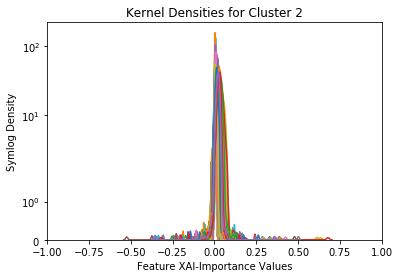

Cluster 3 with centroid [0.21 0.21 0.32 0.43 0.18 0.26 0.22 0.43 0.23 0.26 0.79 0.84 0.53 0.75
 0.64 0.7  0.72 0.75 0.76 0.81 0.57 0.76 0.68 0.73 0.71 0.73 0.76 0.6
 0.78 0.65 0.73 0.83 0.8  0.81 0.59 0.56 0.53 0.55 0.5  0.58 0.59 0.7
 0.65 0.68 0.77 0.56 0.61 0.61 0.64 0.62 0.73 0.7  0.69 0.71 0.75]
And mean importances [0.02 0.03 0.02 0.01 0.02 0.02 0.03 0.02 0.03 0.02 0.01 0.   0.03 0.03
 0.01 0.01 0.01 0.02 0.02 0.   0.02 0.02 0.01 0.01 0.01 0.02 0.01 0.03
 0.03 0.01 0.01 0.   0.01 0.02 0.01 0.03 0.03 0.02 0.03 0.02 0.02 0.03
 0.02 0.04 0.02 0.01 0.01 0.02 0.02 0.01 0.02 0.02 0.03 0.03 0.02]


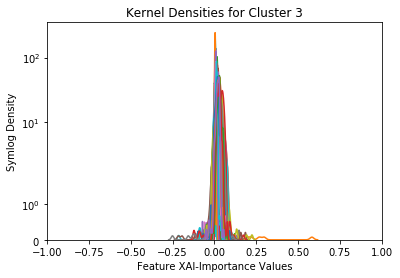

Cluster 4 with centroid [0.28 0.28 0.38 0.21 0.24 0.17 0.11 0.33 0.16 0.25 0.56 0.55 0.32 0.54
 0.27 0.41 0.39 0.45 0.45 0.57 0.51 0.53 0.3  0.43 0.41 0.4  0.46 0.4
 0.47 0.32 0.36 0.64 0.44 0.37 0.44 0.22 0.33 0.34 0.19 0.22 0.21 0.45
 0.37 0.38 0.56 0.13 0.3  0.14 0.22 0.26 0.36 0.35 0.31 0.26 0.46]
And mean importances [0.02 0.02 0.02 0.02 0.02 0.02 0.03 0.02 0.03 0.02 0.01 0.01 0.01 0.01
 0.02 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.01
 0.01 0.02 0.02 0.01 0.02 0.03 0.01 0.02 0.02 0.01 0.02 0.02 0.02 0.01
 0.02 0.02 0.01 0.03 0.02 0.03 0.02 0.03 0.02 0.02 0.03 0.04 0.01]


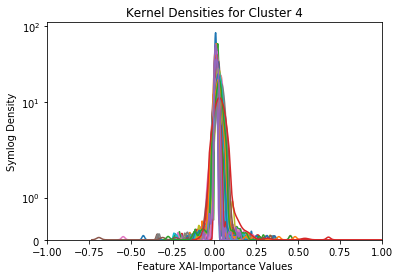

Cluster 5 with centroid [ 0.05  0.05  0.09  0.26  0.17  0.07  0.01  0.17 -0.04  0.15  0.55  0.69
 -0.01  0.16  0.4   0.42  0.56  0.3   0.35  0.62  0.15  0.24  0.45  0.42
  0.44  0.3   0.43  0.06  0.22  0.44  0.47  0.69  0.45  0.45  0.39  0.07
 -0.01  0.06 -0.06  0.11  0.11  0.15  0.26 -0.02  0.3   0.29  0.38  0.15
  0.28  0.35  0.36  0.24  0.15  0.23  0.28]
And mean importances [0.02 0.02 0.03 0.01 0.01 0.02 0.03 0.02 0.03 0.02 0.01 0.   0.03 0.04
 0.01 0.01 0.01 0.02 0.02 0.   0.02 0.03 0.01 0.01 0.01 0.01 0.01 0.03
 0.03 0.01 0.01 0.   0.01 0.01 0.01 0.02 0.03 0.03 0.03 0.02 0.02 0.03
 0.02 0.05 0.02 0.01 0.01 0.02 0.01 0.01 0.01 0.02 0.02 0.02 0.02]


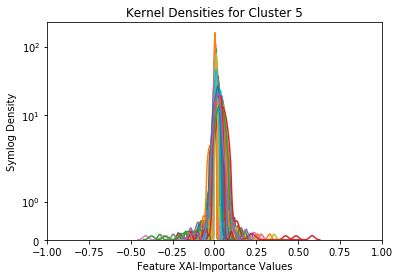

Cluster 6 with centroid [0.62 0.65 0.74 0.62 0.59 0.57 0.66 0.77 0.68 0.65 0.79 0.86 0.61 0.73
 0.69 0.75 0.8  0.79 0.75 0.84 0.65 0.72 0.75 0.78 0.8  0.78 0.78 0.67
 0.76 0.73 0.82 0.9  0.87 0.83 0.69 0.59 0.65 0.65 0.61 0.68 0.62 0.73
 0.73 0.69 0.79 0.64 0.7  0.64 0.65 0.77 0.8  0.77 0.81 0.78 0.78]
And mean importances [0.03 0.03 0.03 0.01 0.02 0.02 0.03 0.03 0.04 0.02 0.   0.   0.03 0.02
 0.01 0.01 0.01 0.02 0.01 0.   0.02 0.02 0.01 0.01 0.01 0.02 0.01 0.03
 0.02 0.01 0.01 0.   0.02 0.01 0.01 0.02 0.03 0.03 0.03 0.03 0.02 0.02
 0.02 0.03 0.02 0.01 0.01 0.02 0.01 0.02 0.02 0.02 0.03 0.02 0.02]


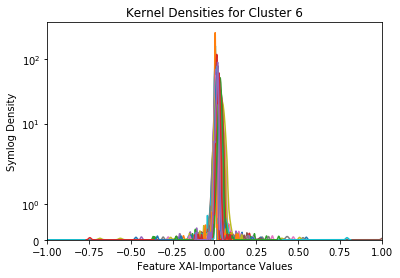

Cluster 7 with centroid [0.81 0.82 0.87 0.79 0.78 0.76 0.83 0.89 0.84 0.83 0.87 0.92 0.75 0.83
 0.84 0.87 0.9  0.89 0.86 0.9  0.76 0.8  0.87 0.86 0.88 0.87 0.86 0.78
 0.84 0.84 0.89 0.95 0.93 0.9  0.82 0.7  0.8  0.77 0.75 0.79 0.75 0.84
 0.83 0.81 0.86 0.79 0.83 0.81 0.79 0.87 0.88 0.87 0.9  0.88 0.87]
And mean importances [0.03 0.03 0.03 0.02 0.03 0.03 0.04 0.03 0.04 0.03 0.01 0.   0.02 0.02
 0.02 0.01 0.01 0.02 0.01 0.   0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.02
 0.01 0.01 0.01 0.   0.01 0.01 0.01 0.02 0.03 0.02 0.03 0.02 0.02 0.02
 0.01 0.03 0.01 0.02 0.02 0.03 0.02 0.02 0.01 0.02 0.03 0.02 0.02]


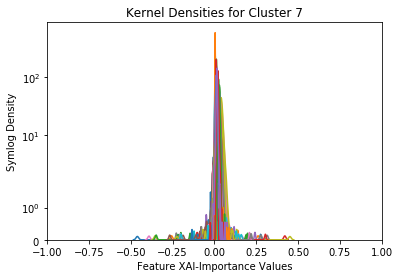

In [22]:
import warnings
warnings.filterwarnings("ignore")

for i in range(nKM):
    print("Cluster", i, "with centroid", CentroidsNaive[i].round(2))
    print("And mean importances", XAI[LabelNaiveOrdered==i,:].mean(0).round(2))
    plt.yscale("symlog", linthresh=1)

    for j in range(min(CorrMatrices.shape[1],100)):
        sns.kdeplot(XAI[LabelNaiveOrdered==i,j], label="Feature " +str(j))
    plt.xlim([-1, 1])
    plt.title("Kernel Densities for Cluster "+str(i))
    plt.ylabel("Symlog Density")
    plt.xlabel("Feature XAI-Importance Values")
    #plt.legend()
    plt.show()

In [23]:
for i in range(nKM):
    print(max(XAI[LabelNaiveOrdered==i,:].mean(0)))

0.03981925101486132
0.037948743600780814
0.039082244870960764
0.0405368526383558
0.03860965663910749
0.04915937975744918
0.03912992981276295
0.04097543219677852


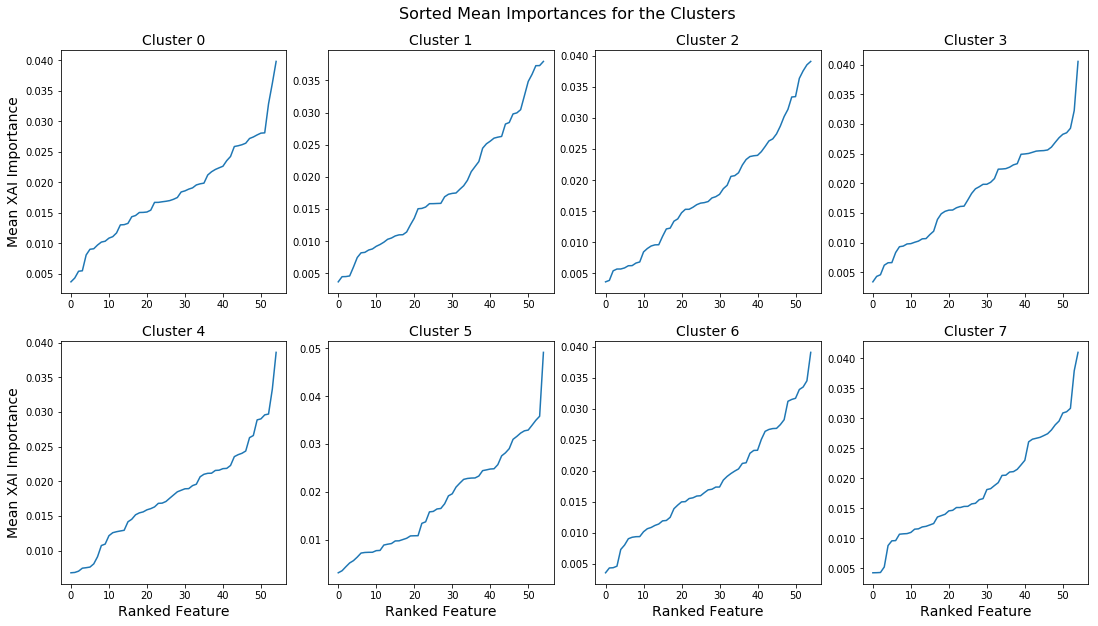

In [24]:
fig, axs = plt.subplots(2, 4,figsize=(15,8))
fig.suptitle("Sorted Mean Importances for the Clusters", fontsize = 16,y=1.05)
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

axs[0,0].set_ylabel("Mean XAI Importance", fontsize=14)
axs[1,0].set_ylabel("Mean XAI Importance", fontsize=14)

for i in range(4):
    axs[0,i].set_title("Cluster "+ str(i), fontsize=14)
    axs[0,i].plot(np.sort(XAI[LabelNaiveOrdered==i,:].mean(0)))
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)

for i in range(4):
    axs[1,i].set_title("Cluster "+ str(i+4), fontsize=14)
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)
    axs[1,i].plot(np.sort(XAI[LabelNaiveOrdered==i+4,:].mean(0)))
plt.show()    

At least for some clusters, one can clearly see an elbow-curve-behaviour at the left and/or right extremes of the feature ranking.

## Now aggregated across all clusters

Text(0.5, 0, 'Sorted Features')

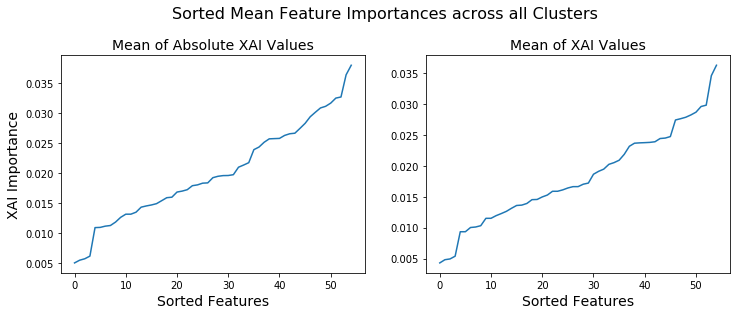

In [25]:
f, ax = plt.subplots( 1,2,figsize=(12,4))
f.suptitle("Sorted Mean Feature Importances across all Clusters", fontsize = 16,y=1.05)

ax[0].set_ylabel("XAI Importance", fontsize=14)

ax[0].set_title("Mean of Absolute XAI Values", fontsize=14)
ax[0].plot(np.sort(abs(XAI).mean(0)))
ax[0].set_xlabel("Sorted Features", fontsize=14)

ax[1].set_title("Mean of XAI Values", fontsize=14)
ax[1].plot(np.sort(XAI.mean(0)))
ax[1].set_xlabel("Sorted Features", fontsize=14)


These are some interesting plots and also show elbow curves for the means. The means of absolute values are less clear to interpret as a sigmoid/elbos

## Export some Plots

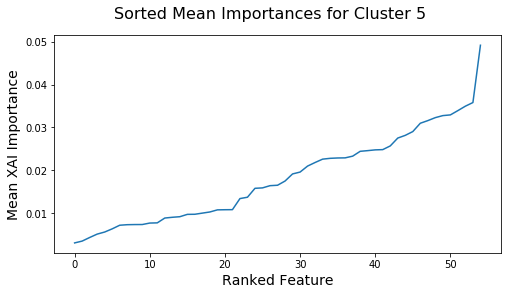

In [26]:
j = 5

fig, axs = plt.subplots(1, 1,figsize=(8,4))
fig.suptitle("Sorted Mean Importances for Cluster "+str(j), fontsize = 16)
#fig.tight_layout()
#fig.subplots_adjust(hspace=0.2)

#axs,set_title("Sorted Mean Importances for Cluster 2")
axs.set_ylabel("Mean XAI Importance", fontsize=14)
axs.plot(np.sort(XAI[LabelNaiveOrdered==j,:].mean(0)))
axs.set_xlabel('Ranked Feature', fontsize=14)
fig.savefig("XAI_Cluster"+str(j)+".png",  dpi=800)

In [27]:
# Export the corresponding data
np.save("XAI_Data_Cluster5.npy",
        XAI[LabelNaiveOrdered==j,:].mean(0))

## Detecting the Elbow

Use a linear interpolation before the elbow or at the centre of the curve. Then, assume that the elbow is at the consecutively n last ranked instances for which the XAI-value is above 3*sigma + linear regression.

In [28]:

def DetectElbow(Data, lower, upper, Deviation = 3, plot = False):
    # Input: Data and a lower/upper index for the range to use for linear interpolation
    # output: The index I for which all Data[-i:-1] are clearly above the linear regression
    #         i.e. the elbow starts at Data[-i]
    #         and all Features which are deemed relevant
    
    Index = np.argsort(Data)
    Sorted = np.sort(Data)
    LR = linregress(np.arange(lower, upper),
                   Sorted[lower:upper])
    
    residua = Sorted - (LR.intercept + LR.slope * np.arange(len(Data)))
    
    Output = None
    RelevantIndex = None
    if residua[-1] > Deviation* LR.stderr:
        Check = True
        i = 1
        while Check:
            i+=1
            Check = (residua[len(residua)-i] > Deviation*LR.stderr)
        Output = i
        RelevantIndex = Index[len(Index)-i+1:] # last i Index values, i,e. highest values
    
    if plot:
            plt.plot(Sorted)
            plt.plot(LR.intercept + LR.slope * np.arange(len(Data)))
            plt.axvline(len(residua)-i,
                       c="red")
            plt.show()
    
    return([Output-1, RelevantIndex])

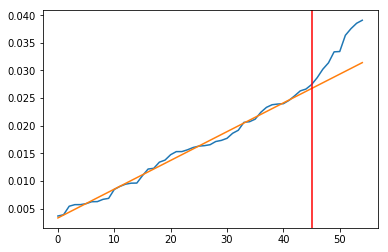

[9, array([38,  0, 36, 52,  2,  1,  6, 43,  8])]

In [29]:
DetectElbow(XAI[LabelNaiveOrdered==2,:].mean(0), 0, 45, 100, True)

In [30]:
AllRelevant = np.array([])

for j in range(nKM):
    DE = DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, False)
    print(j, DE)
    AllRelevant=np.concatenate([AllRelevant,DE[1]])
print(AllRelevant)

0 [3, array([47,  6,  8])]
1 [9, array([ 9, 37,  2,  8,  1,  0,  4,  6,  5])]
2 [8, array([ 0, 36, 52,  2,  1,  6, 43,  8])]
3 [2, array([38, 43])]
4 [6, array([33, 45,  6,  8, 47, 53])]
5 [9, array([ 6, 37, 27, 36,  8, 12, 38, 13, 43])]
6 [7, array([ 2, 36, 43, 38, 52,  6,  8])]
7 [7, array([ 5,  2, 38,  1,  0,  6,  8])]
[47.  6.  8.  9. 37.  2.  8.  1.  0.  4.  6.  5.  0. 36. 52.  2.  1.  6.
 43.  8. 38. 43. 33. 45.  6.  8. 47. 53.  6. 37. 27. 36.  8. 12. 38. 13.
 43.  2. 36. 43. 38. 52.  6.  8.  5.  2. 38.  1.  0.  6.  8.]


In [31]:
np.array(np.unique(AllRelevant, return_counts=True)).T

array([[ 0.,  3.],
       [ 1.,  3.],
       [ 2.,  4.],
       [ 4.,  1.],
       [ 5.,  2.],
       [ 6.,  7.],
       [ 8.,  7.],
       [ 9.,  1.],
       [12.,  1.],
       [13.,  1.],
       [27.,  1.],
       [33.,  1.],
       [36.,  3.],
       [37.,  2.],
       [38.,  4.],
       [43.,  4.],
       [45.,  1.],
       [47.,  2.],
       [52.,  2.],
       [53.,  1.]])

(array([3., 3., 4., 0., 1., 2., 7., 0., 7., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 3., 2., 4., 0., 0., 0., 0., 4., 0., 1., 0., 2., 0., 0., 0.,
        0., 2.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
        32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5,
        43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5]),
 <a list of 53 Patch objects>)

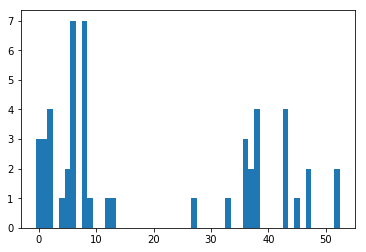

In [32]:
plt.hist(AllRelevant, bins = np.arange(-0.5,
                                       max(AllRelevant)+0.5,1))

### Transform back to original sectors

In [33]:
def ReverseDiag(Array, ZERO = False):
    N = np.sqrt(2*len(Array)+0.25)+0.5
    N = int(N)
    Original = np.ones(int(N**2.)).reshape(1,-1)
    
    if ZERO:
        Original = np.zeros(int(N**2.)).reshape(1,-1)
    
    index = np.triu(np.ones((N,N)),1)
    index = index.reshape(1,-1)
    index = index.astype(bool)
    
    Original[index] = Array # upper triangle
    Original = Original.reshape((N,N))
    Original = Original.T  # guarantee symmetry
    Original=Original.reshape(1,-1)
    Original[index] = Array
    Original=Original.reshape((N,N))

    return(Original)

In [34]:
print(DF.columns)
# E: Energy, CD: Constumer Discretionary, F: Financials, I: Industrials, U: Utilities, CS: Constumer Staples,
# RE: Real Estate, Com: Communication Services, M: Materials, IT: Information Technology
Names = ["E", "CD", "F", "I", "U", "CS", "RE", "Com", "M", "IT", "HC"]

Index(['Energy', 'Consumer Discretionary', 'Financials', 'Industrials',
       'Utilities', 'Consumer Staples', 'Real Estate',
       'Communication Services', 'Materials', 'Information Technology',
       'Health Care'],
      dtype='object')


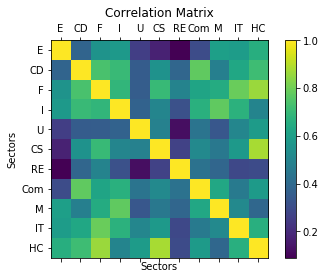

In [35]:
def plot_matrix(m, title='Correlation Matrix', cmap=plt.cm.Blues, labels=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(m)
    plt.title(title,y=1.08)
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('Sectors')
    plt.ylabel('Sectors')
    plt.show()
    
plot_matrix(ReverseDiag(CorrMatrices[1,:]),
           labels = Names)

### Plot Relevances

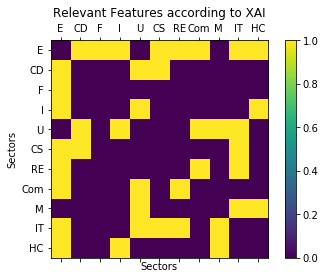

In [36]:
RelevantCombined = np.array(list(set(AllRelevant))).astype("int")
RelevancePlot = np.zeros(55)
RelevancePlot[RelevantCombined] = 1.
plot_matrix(ReverseDiag(RelevancePlot,
                       ZERO = True),
            title = "Relevant Features according to XAI",
           labels = Names)

In [37]:
def PrintNames(Mat, Names):
    Out = list()
    for i in range(Mat.shape[0]):
        for j in range(i+1, Mat.shape[1]):
            if Mat[i,j]==1:
                Out.append(Names[i]+"/"+Names[j])
    return(Out)
                

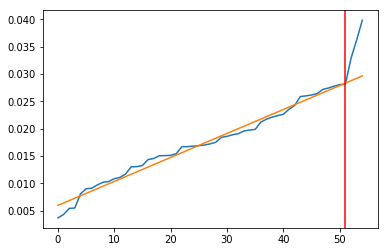

0 3 [47  6  8]


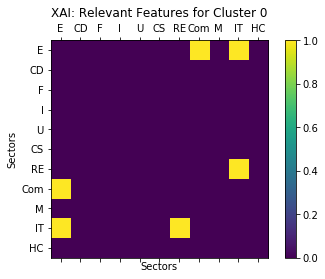

Relevant Correlations: ['E/Com', 'E/IT', 'RE/IT']
 # # # # 


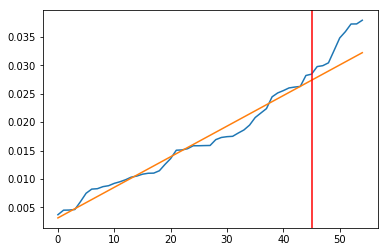

1 9 [ 9 37  2  8  1  0  4  6  5]


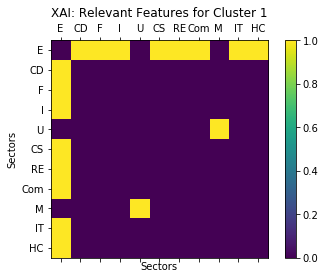

Relevant Correlations: ['E/CD', 'E/F', 'E/I', 'E/CS', 'E/RE', 'E/Com', 'E/IT', 'E/HC', 'U/M']
 # # # # 


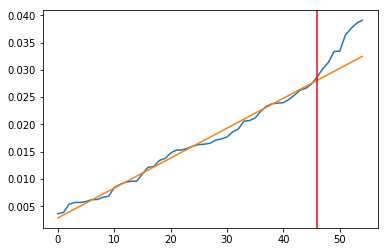

2 8 [ 0 36 52  2  1  6 43  8]


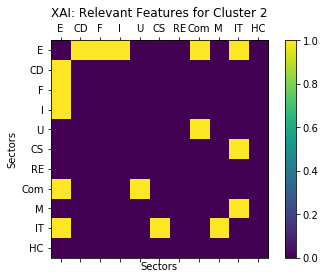

Relevant Correlations: ['E/CD', 'E/F', 'E/I', 'E/Com', 'E/IT', 'U/Com', 'CS/IT', 'M/IT']
 # # # # 


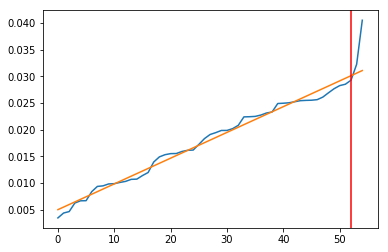

3 2 [38 43]


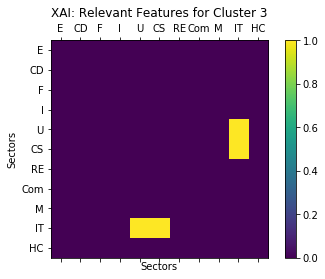

Relevant Correlations: ['U/IT', 'CS/IT']
 # # # # 


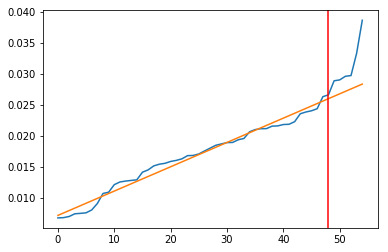

4 6 [33 45  6  8 47 53]


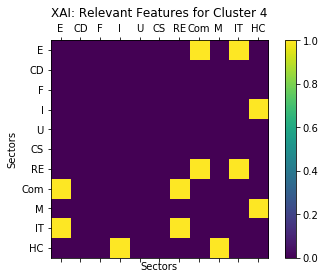

Relevant Correlations: ['E/Com', 'E/IT', 'I/HC', 'RE/Com', 'RE/IT', 'M/HC']
 # # # # 


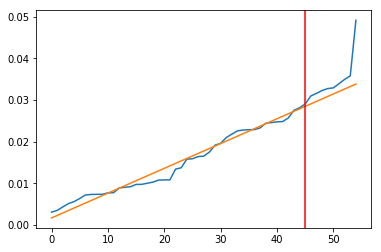

5 9 [ 6 37 27 36  8 12 38 13 43]


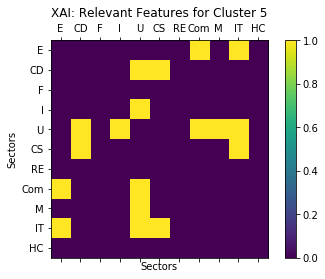

Relevant Correlations: ['E/Com', 'E/IT', 'CD/U', 'CD/CS', 'I/U', 'U/Com', 'U/M', 'U/IT', 'CS/IT']
 # # # # 


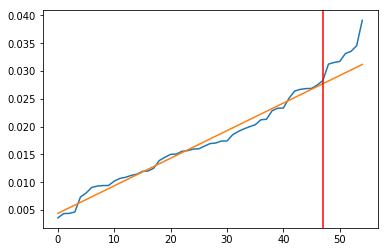

6 7 [ 2 36 43 38 52  6  8]


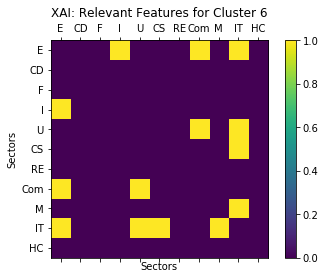

Relevant Correlations: ['E/I', 'E/Com', 'E/IT', 'U/Com', 'U/IT', 'CS/IT', 'M/IT']
 # # # # 


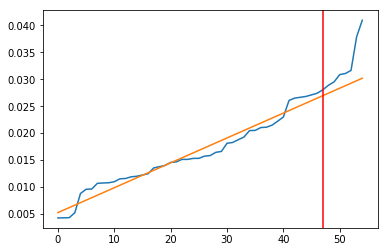

7 7 [ 5  2 38  1  0  6  8]


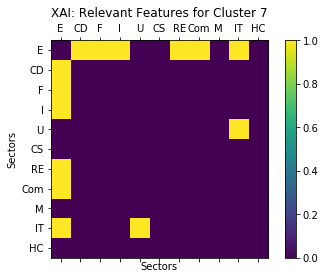

Relevant Correlations: ['E/CD', 'E/F', 'E/I', 'E/RE', 'E/Com', 'E/IT', 'U/IT']
 # # # # 


In [38]:
# and plots for each Cluster
for j in range(nKM):
    #DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, True)
    DE = DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, True)
    print(j, DE[0], DE[1] )
    
    relIndex = np.zeros(55)
    relIndex[DE[1]] = 1.
    RelMat = ReverseDiag(relIndex,
                       ZERO = True)
    plot_matrix(RelMat,
            title = "XAI: Relevant Features for Cluster "+str(j),
           labels = Names)
    print("Relevant Correlations:",PrintNames(RelMat, Names))
    
    print(" # # # # ")

In [52]:
np.save("XAI_Finance",XAI)
np.save("LabelNaiveOrdered",
       LabelNaiveOrdered)
np.save("Names", Names)